In [1]:
import fenics
import time

import seaborn as sns
import pandas as pd
import numpy as np
import chaospy as cpy
import matplotlib.pyplot as plt

from copy import deepcopy
from chaospy import Normal, Uniform, generate_expansion
from fenics import UnitSquareMesh, Expression, Constant, Function
from fenics import FunctionSpace, TrialFunction, TestFunction, DirichletBC
from fenics import dot, grad, solve, plot, dx, errornorm, lhs, rhs

from source.models.high_fidelity import HighFidelityModel
from source.models.chaos_expansion import PCESurrogate
from source.core.metropolis_hastings import metropolis_hastings, adaptive_multifidelity_mh

In [2]:
fenics.set_log_level(30)
np.random.seed(1226)
sns.set_style('whitegrid')

In [3]:
class PoissonEquation:
    def __init__(self, grid_shape, f, init_z, dirichlet, degree=1, polynomial_type='P'):
        def boundary(x, on_boundary):
            return on_boundary

        self.grid_shape = grid_shape
        self.mesh = UnitSquareMesh(*grid_shape)
        self.V = FunctionSpace(self.mesh, polynomial_type, degree)
        self.dirichlet = DirichletBC(self.V, Expression(dirichlet, degree=degree+3), boundary)
        self._paramnames = ['param{}'.format(i) for i in range(len(init_z))]
        self.f = Expression(f, degree=degree, **dict(zip(self._paramnames, init_z)))
        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        self.a = dot(grad(u), grad(v)) * dx
        self.L = self.f * v * dx
        self.u = Function(self.V)

    def _solve(self, z):
        for key, val in zip(self._paramnames, z):
            self.f.user_parameters[key] = val
        solve(self.a == self.L, self.u, self.dirichlet)

    def __call__(self, z, x):
        self._solve(z)
        return np.array([np.log(self.u(x_)) for x_ in x.T])

    def plot(self, z):
        self._solve(z)
        plt.figure()
        plt.contourf(
            np.log(self.u.compute_vertex_values(self.mesh).reshape(*(self.grid_shape + 1))),
            cmap='viridis')
        plt.show()

In [4]:
forward_model = PoissonEquation(
    np.array([32, 32]), 'exp(-100*(pow(x[0] - param0, 2) + pow(x[1] - param1, 2)))',
    np.array([.5, .5]), '0')

In [5]:
tol = 1e-5
num_data = 100
noise_sigma = .75
true_z = np.array([.25, .75])
x = np.random.uniform(0 + tol, 1 - tol, size=(2, num_data))
true_vals = forward_model(true_z, x)
data = true_vals + np.random.normal(0, noise_sigma, size=true_vals.shape)

In [6]:
dim = 2
prior = cpy.Iid(Uniform(0 + tol, 1 - tol), dim)

In [7]:
def log_prior(z_):
    z_ = np.min([z_, np.ones_like(z_) - tol], axis=0)
    z_ = np.max([z_, np.zeros_like(z_) + tol], axis=0)
    return np.log(prior.pdf(z_))

def log_err_dens(x_):
    return np.sum(-x_**2/(2*noise_sigma**2))

class UnifProposal:
    def __init__(self, r):
        self.r = r

    def draw(self, z):
        lbs = np.max([z - self.r, np.zeros_like(z) - tol], axis=0)
        ubs = np.min([z + self.r, np.ones_like(z) + tol], axis=0)
        return np.random.uniform(lbs, ubs, size=z.shape)

    def logdensity(self, z1, z2):
        lbs = np.max([z2 - self.r, np.zeros_like(z2) - tol], axis=0)
        ubs = np.min([z2 + self.r, np.ones_like(z2) + tol], axis=0)
        dens = 1./np.prod(ubs-lbs)
        return np.log(dens) if np.all(np.abs(z1 - z2) <= self.r) else -np.inf

In [8]:
hfm = HighFidelityModel(
    forward_model, data, x, log_err_dens, log_prior)

lfm = PCESurrogate(data, log_err_dens, prior, log_prior, 2, 10)
lfm.fit(hfm)

mfm = deepcopy(lfm)

In [9]:
proposal = UnifProposal(.05)
samples = 1000
init_z = np.array([.5, .5])

subchain_len = 100
upper_th = 1e-4
error_th = 1e-2
init_radius = .1
rho = .9

In [10]:
lfmh_t = time.time()
lfmh = metropolis_hastings(lfm, proposal, init_z, samples)
lfmh_t = time.time() - lfmh_t

100% |=================================| ETA:  00:00:00 - Elapsed Time: 0:00:07

In [11]:
hfmh_t = time.time()
hfmh = metropolis_hastings(hfm, proposal, init_z, samples)
hfmh_t = time.time() - hfmh_t

 99% |================================ | ETA:   0:00:00 - Elapsed Time: 0:00:12

In [12]:
mfmh_t = time.time()
mfmh = adaptive_multifidelity_mh(
    subchain_len, samples // subchain_len, upper_th, error_th, init_radius, rho, mfm, hfm, proposal, init_z)
mfmh_t = time.time() - mfmh_t

100% |=================================| ETA:  00:00:00 - Elapsed Time: 0:00:07

In [13]:
print('\nperformance evaluation:')
print('\tlow fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(lfmh_t, lfmh_t/samples))
print('\thigh fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(hfmh_t, hfmh_t/samples))
print('\tmulti fidelity:\t{:.2f}s ({:.4}s per iteration)'.format(mfmh_t, mfmh_t/samples))


performance evaluation:
	low fidelity:	7.45s (0.007452s per iteration)
	high fidelity:	12.36s (0.01236s per iteration)
	multi fidelity:	7.78s (0.007785s per iteration)


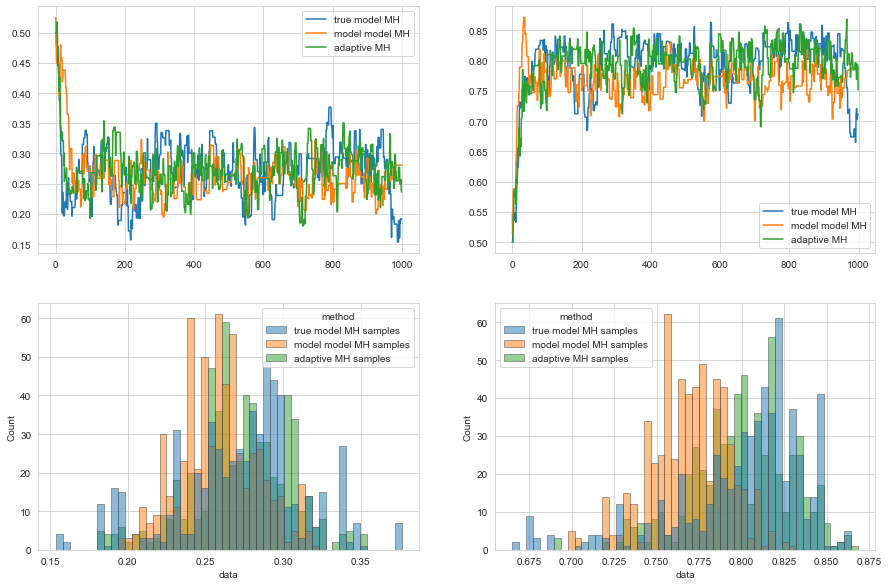

In [16]:
plt.figure(figsize=(15, 10))

for i in range(2):
    plt.subplot(2, 2, i+1)
    plt.plot(hfmh[i, :], label='true model MH')
    plt.plot(lfmh[i, :], label='model model MH')
    plt.plot(mfmh[i, :], label='adaptive MH')
    plt.legend()

burn = 400
for i in range(2):
    plt.subplot(2, 2, i+3)

    mh_data = pd.DataFrame({
        'data': np.concatenate([hfmh[i, burn:], lfmh[i, burn:], mfmh[i, burn:]], axis=0),
        'method':
            ['true model MH samples'] * (samples - burn) +
            ['model model MH samples'] * (samples - burn) +
            ['adaptive MH samples'] * (samples - burn)})
    sns.histplot(
        mh_data,
        x='data',
        hue='method',
        bins=50,
        multiple='layer',
        edgecolor='.3',
        linewidth=.5)

plt.show()